# Dimensionality Reduction for Training Set

It isn't feasible to use all ~20,000 genes during training. Instead, we can use dimensionality reduction to create a new set of features and train on those.

# Inputs

In [11]:
import rnaseq_lib3 as r

from sklearn.decomposition import PCA
from sklearn import preprocessing

import pandas as pd
import numpy as np
import pymc3 as pm
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Read in centered data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt_centered.hd5')
# Subset
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal'].sort_values('tissue')
tumor = df[df.label == 'tcga-tumor'].sort_values('tissue')
# Read in drug genes
genes = df.columns[5:]
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

# Normal

## Current Method (Gene Subset)

In [19]:
sample = tumor.loc['TCGA-KK-A7B2-01']
classes = normal.tissue.unique()

In [4]:
training_genes = r.outlier.select_k_best_genes(normal, genes, 'tissue', n=50)
training_genes += ['ARAF', 'PARP1']

In [5]:
m, t = r.outlier.run_model(sample, normal, 'tissue', 
                           training_genes=training_genes,
                           beta_func=pm.LogitNormal)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [13:49<00:00,  2.55draws/s] 
The number of effective samples is smaller than 25% for some parameters.


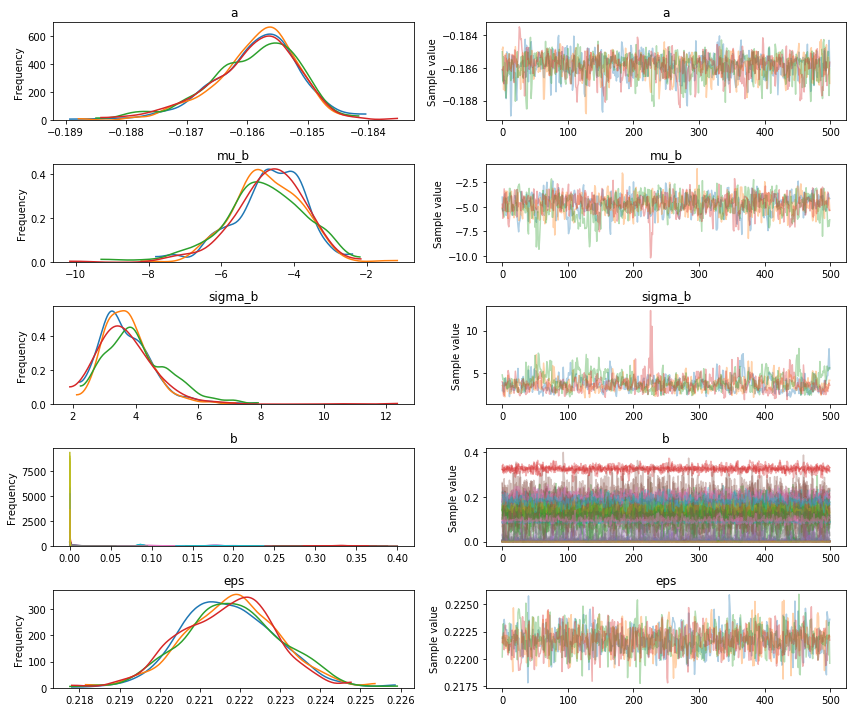

In [6]:
pm.traceplot(t);

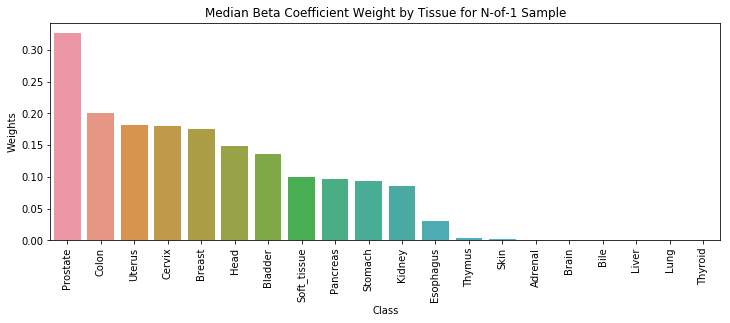

In [7]:
r.outlier.plot_weights(classes, t)

In [8]:
ppc = pm.sample_ppc(t, model=m)

100%|██████████| 500/500 [00:24<00:00, 20.42it/s]


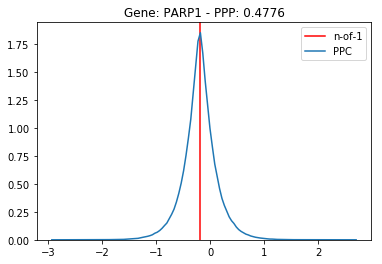

In [174]:
gene = 'PARP1'
z_true = sample[gene]
z = ppc[gene].ravel()

plt.axvline(z_true, label='n-of-1', c='r')
sns.kdeplot(z, label='PPC')
ppp = round(sum(z_true < z) / len(z), 4)
plt.title(f'Gene: {gene} - PPP: {ppp}');

## PCA (Class Unaware)

In [3]:
from sklearn.decomposition import PCA

In [28]:
n = 50
X_genes = [f'Gene{x}' for x in range(n)]
pca = PCA(n_components=n)

Add sample to combined df

In [29]:
combined_df = normal.append(sample)

Perform PCA then extract sample

In [39]:
genes = df.columns[5:]
X = pca.fit_transform(combined_df[genes])

TEST: Try normalizing 

In [40]:
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
#X = pd.DataFrame(x_scaled)

In [41]:
y = pd.Series(X[-1, :], index=X_genes)

In [42]:
X = X[:-1, :]
X = pd.DataFrame(X, index=normal.index)
X.columns = X_genes

Add back in metadata

In [43]:
for col in df.columns[:5]:
    X[col] = df[col]
    y[col] = sample[col]

### Component Distributions

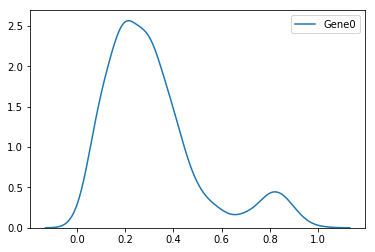

In [47]:
sns.kdeplot(X.Gene0)

### Run Model

In [48]:
m_pca, t_pca = r.outlier.run_model(y, X, 'tissue', 
                                   training_genes=X_genes)
                                   #beta_func=pm.LogitNormal)

INFO (theano.gof.compilelock): Waiting for existing lock by process '30874' (I am process '26216')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '30874' (I am process '26216')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '30874' (I am process '26216')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '30874' (I am process '26216')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubunt

INFO (theano.gof.compilelock): Waiting for existing lock by process '30874' (I am process '26216')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '30874' (I am process '26216')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '30874' (I am process '26216')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubuntu/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '30874' (I am process '26216')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/ubunt

KeyboardInterrupt: 

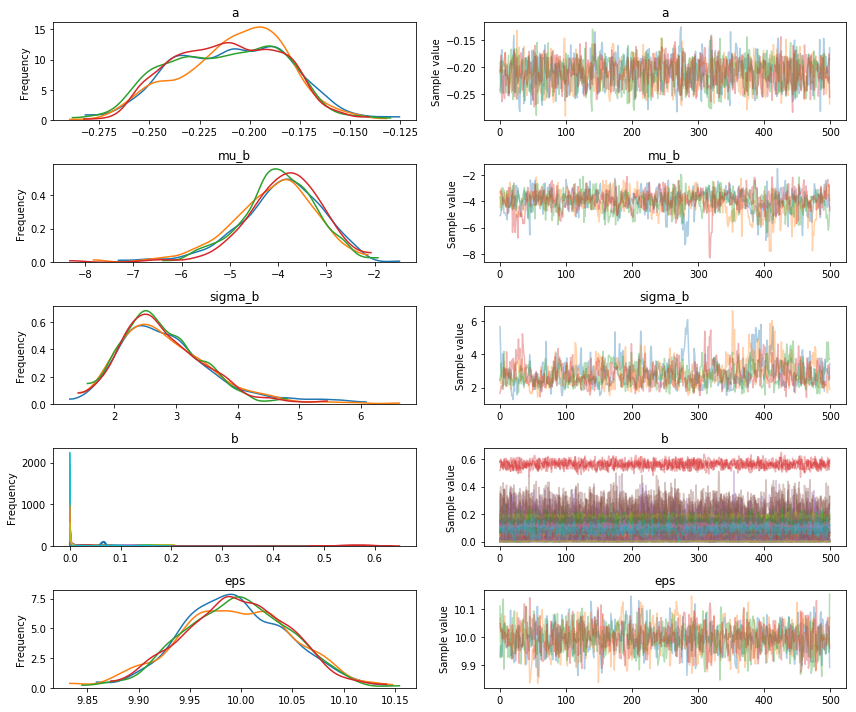

In [188]:
pm.traceplot(t_pca);

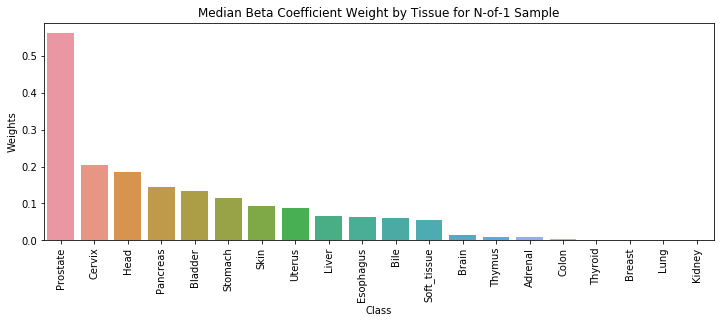

In [189]:
r.outlier.plot_weights(classes, t_pca)

In [190]:
ppc_pca = pm.sample_ppc(t_pca, model=m_pca)

100%|██████████| 500/500 [00:46<00:00, 10.82it/s] 


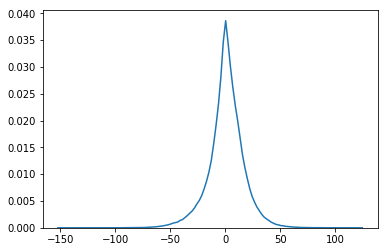

In [56]:
sns.kdeplot(ppc_pca['Gene0'].ravel())

## Linear Discriminant Analysis (Class Aware)

In [94]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [97]:
y = normal.tissue.tolist() + ['cancer']

In [101]:
lda = LinearDiscriminantAnalysis(n_components=50)
X_lda = lda.fit(combined_df[genes], y).transform(combined_df[genes])

In [111]:
X_genes = [f'Gene{x}' for x in range(20)]

In [112]:
y = pd.Series(X_lda[-1, :], index=X_genes)

In [113]:
X = X_lda[:-1, :]
X = pd.DataFrame(X, index=normal.index)
X.columns = X_genes

In [114]:
for col in df.columns[:5]:
    X[col] = df[col]
    y[col] = sample[col]

In [115]:
m_lda, t_lda = r.outlier.run_model(y, X, 'tissue', 
                                   training_genes=X_genes,
                                   beta_func=pm.LogitNormal)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [04:55<00:00,  3.78draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


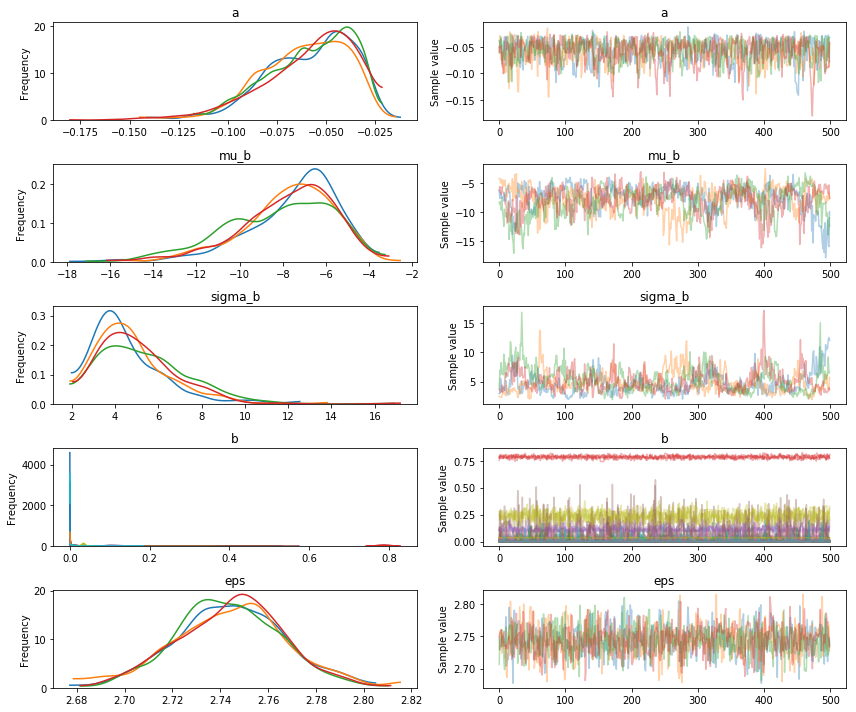

In [116]:
pm.traceplot(t_lda);

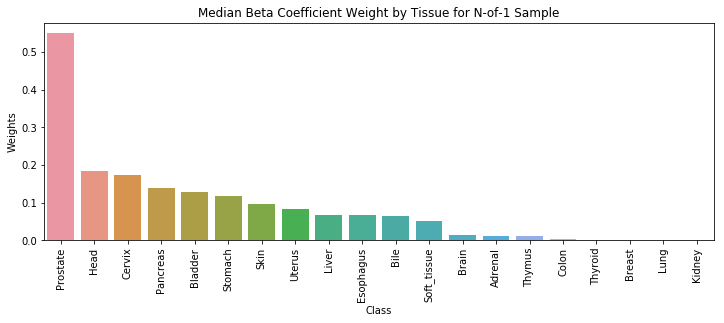

In [117]:
r.outlier.plot_weights(classes, t_pca)

## PCA, Add in drug_genes

In [20]:
n = 50
X_genes = [f'Gene{x}' for x in range(n)] + ['ARAF', 'PARP1']
pca = PCA(n_components=n)

Add sample to combined df

In [21]:
combined_df = normal.append(sample)

Perform PCA on dataframe (minus drug genes)

In [22]:
X = pca.fit_transform(combined_df[genes].drop(['ARAF', 'PARP1'], axis=1))

Add in back drug genes

In [23]:
X = np.append(X, np.array(combined_df[['ARAF', 'PARP1']]), axis=1)

In [24]:
y = pd.Series(X[-1, :], index=X_genes)

In [25]:
X = X[:-1, :]
X = pd.DataFrame(X, index=normal.index)
X.columns = X_genes

Add back in metadata

In [26]:
for col in df.columns[:5]:
    X[col] = df[col]
    y[col] = sample[col]

In [27]:
m_pca_dg, t_pca_dg = r.outlier.run_model(y, X, 'tissue', 
                                   training_genes=X_genes,
                                   beta_func=pm.LogitNormal)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [13:12<00:00,  3.05draws/s] 
The estimated number of effective samples is smaller than 200 for some parameters.


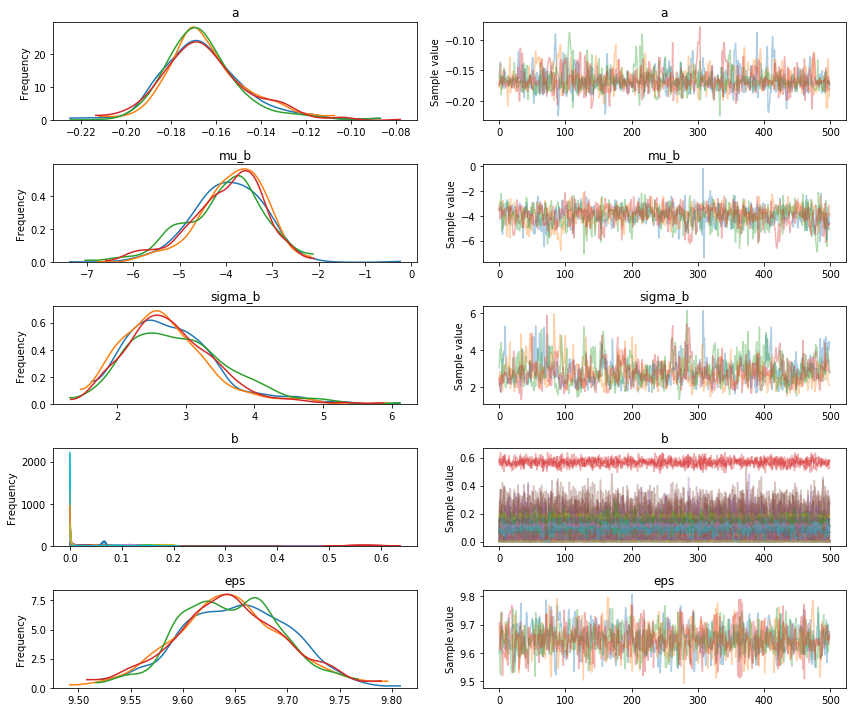

In [28]:
pm.traceplot(t_pca_dg);

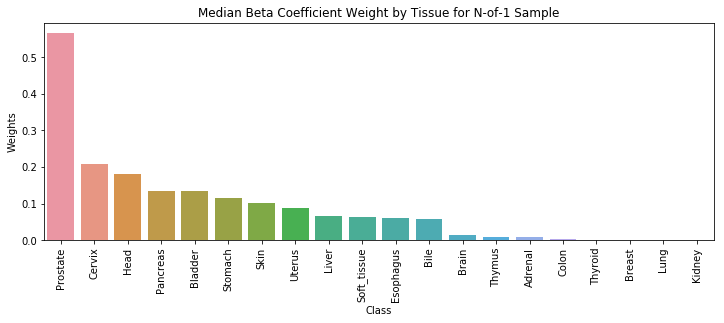

In [29]:
r.outlier.plot_weights(classes, t_pca_dg)

In [30]:
ppc = pm.sample_ppc(t_pca_dg, model=m_pca_dg)

100%|██████████| 500/500 [00:35<00:00, 13.90it/s]


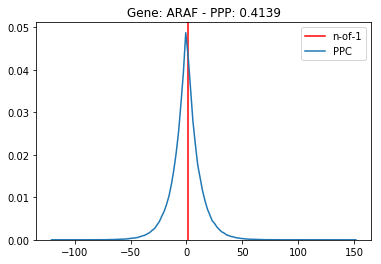

In [31]:
gene = 'ARAF'
z_true = sample[gene]
z = ppc[gene].ravel()

plt.axvline(z_true, label='n-of-1', c='r')
sns.kdeplot(z, label='PPC')
ppp = round(sum(z_true < z) / len(z), 4)
plt.title(f'Gene: {gene} - PPP: {ppp}');

# GTEx

## Current Method (Gene Subset)

In [ ]:
sample = tumor.loc['TCGA-KK-A7B2-01']
classes = normal.tissue.unique()

In [4]:
training_genes = r.outlier.select_k_best_genes(normal, genes, 'tissue', n=50)
training_genes += ['ARAF', 'PARP1']

In [ ]:
m, t = r.outlier.run_model(sample, normal, 'tissue', 
                           training_genes=training_genes,
                           beta_func=pm.LogitNormal)

In [ ]:
pm.traceplot(t);

In [ ]:
r.outlier.plot_weights(classes, t)

# TEST - inferring ppc from linear

Text(0.5, 1.0, 'Gene: PARP1 - PPP: 0.4776')

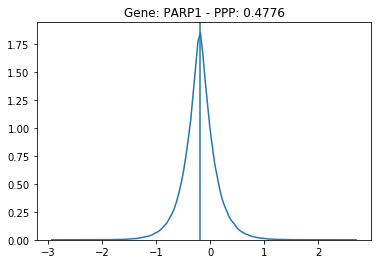

In [10]:
gene = 'PARP1'
z = ppc[gene].ravel()
z_true = sample[gene]
ppp = round(sum(z_true < z) / len(z), 4)
sns.kdeplot(z)
plt.axvline(z_true)
plt.title(f'Gene: {gene} - PPP: {ppp}')

## Use Means of Trace Coefficients and Sample Median

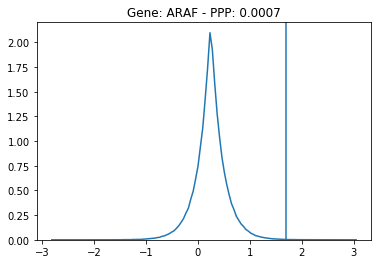

In [37]:
gene = 'ARAF'
z = np.median(t['a'])
for i, g in enumerate(classes):
    samples = normal[normal['tissue'] == g][gene].median()
    z += t['b'][:, i].mean() * samples
    
z = np.random.laplace(loc=z, scale=np.median(t['eps']), size=500000)

z_true = sample[gene]
ppp = round(sum(z_true < z) / len(z), 4)

plt.title(f'Gene: {gene} - PPP: {ppp}')
plt.axvline(sample[gene])
sns.kdeplot(z)

## Enumerate Over Trace, 1 Sample from every Background Dataset

In [40]:
trace = t

In [38]:
gene = 'ARAF'
zs = []
for i, a in tqdm(enumerate(trace['a']), total=len(t['a'])):
    z = a
    for j, g in enumerate(classes):
        samples = np.random.choice(normal[normal['tissue'] == g][gene])
        z += t['b'][i, j] * samples
    zs.append(z)

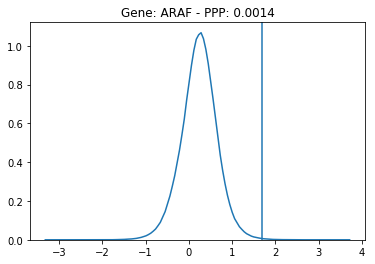

In [42]:
z = np.random.laplace(loc=zs, scale=t['eps'], size=(500, 2000)).ravel()

z_true = sample[gene]
ppp = round(sum(z_true < z) / len(z), 4)

plt.title(f'Gene: {gene} - PPP: {ppp}')
plt.axvline(sample[gene])
sns.kdeplot(z)

## Trace means, 1 sample from every background dataset

Too variable, changes everytime

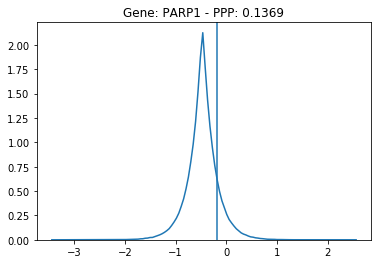

In [113]:
gene = 'PARP1'
z = t['a'].mean()
for i, g in enumerate(classes):
    samples = np.random.choice(normal[normal['tissue'] == g][gene])
    z += t['b'][:, i].mean() * samples
    
z = np.random.laplace(loc=z, scale=t['eps'].mean(), size=500000)

z_true = sample[gene]
ppp = round(sum(z_true < z) / len(z), 4)

plt.title(f'Gene: {gene} - PPP: {ppp}')
plt.axvline(sample[gene])
sns.kdeplot(z)

## Iterate N times and random sample with trace means

In [106]:
gene = 'PARP1'
zs = []
for i in tqdm(range(2000), total=2000):
    z = t['a'].mean()
    for j, g in enumerate(classes):
        samples = np.random.choice(normal[normal['tissue'] == g][gene])
        z += t['b'][:, j].mean() * samples
    zs.append(z)

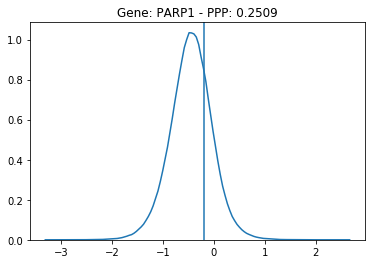

In [111]:
z = np.random.laplace(loc=zs, scale=t['eps'].mean(), size=(200, 2000)).ravel()

z_true = sample[gene]
ppp = round(sum(z_true < z) / len(z), 4)

plt.title(f'Gene: {gene} - PPP: {ppp}')
plt.axvline(sample[gene])
sns.kdeplot(z)

## Dot Product of Weight Vector and X

[sigma_b, b, eps]

In [12]:
idx = normal.tissue.astype('category').cat.codes

In [18]:
b_mean = t['b'].mean(axis=0)
b_vec = np.array([b_mean[i] for i in idx])

In [25]:
t['b'].mean(axis=0)

array([1.99379627e-03, 3.54332642e-04, 1.36446669e-01, 5.51234833e-04,
       1.75795839e-01, 1.80894160e-01, 2.02181554e-01, 3.66278654e-02,
       1.50259241e-01, 8.63841063e-02, 1.55180571e-04, 2.08929094e-04,
       9.45548148e-02, 3.26444928e-01, 9.26279450e-03, 9.84791074e-02,
       9.50777856e-02, 6.42444294e-03, 9.59096458e-05, 1.81654056e-01])

In [22]:
t['a'].mean()

-0.18589226354951285

In [26]:
b_vec.dot(normal.PARP1)

-7.240932787731286

In [21]:
z

-7.426825051280799

## Use one sample at a time (this was it, albeit poor implementation)

`sample_ppc` returns an (N x num_samples) matrix. Let's try to recreate this by iterating over every sample to create a 500 x 726 matrix.

In [ ]:
tissue_codes = {tissue: i for i, tissue in enumerate(normal.tissue.unique())}

In [81]:
zs = np.zeros((500, 726))
for i in tqdm(range(500), total=500):
    for j, (_, row) in enumerate(normal.iterrows()):
        z = trace['a'][i] + trace['b'][i, tissue_codes[row.tissue]] * row[gene]
        zs[i, j] = z

In [92]:
z = np.random.laplace(loc=zs.ravel(), scale=trace['eps'].mean())

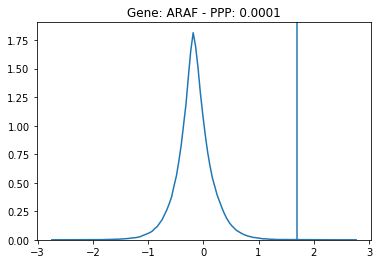

In [93]:
z_true = sample[gene]
ppp = round(sum(z_true < z) / len(z), 4)

plt.title(f'Gene: {gene} - PPP: {ppp}')
plt.axvline(sample[gene])
sns.kdeplot(z)

# Speeding up PPC from Linear

## Subset for genes
70x faster than iterating rows

In [122]:
tissue_codes = {tissue: i for i, tissue in enumerate(normal.tissue.unique())}

In [123]:
gene = "PARP1"

In [126]:
zs = np.zeros((500, 726))
for i in tqdm(range(500), total=500):
    for j, (sample_tissue, sample_gene) in enumerate(zip(normal.tissue, normal[gene])):
        z = trace['a'][i] + trace['b'][i, tissue_codes[sample_tissue]] * sample_gene
        zs[i, j] = z

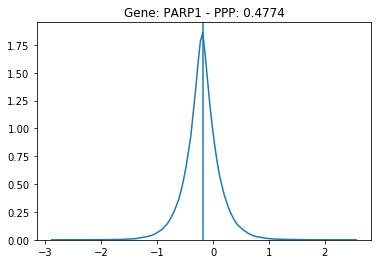

In [127]:
z = np.random.laplace(loc=zs.ravel(), scale=trace['eps'].mean())

z_true = sample[gene]
ppp = round(sum(z_true < z) / len(z), 4)

plt.title(f'Gene: {gene} - PPP: {ppp}')
plt.axvline(sample[gene])
sns.kdeplot(z)

## Vectorize and run multiple genes at a time

In [154]:
zs = {gene: np.zeros((500, len(normal))) for gene in genes}

In [170]:
zs = {gene: np.zeros((500, len(normal))) for gene in genes}
for i in tqdm(range(500), total=500):
    z = trace['a'][i] + normal[genes].mul([trace['b'][i, x] for x in idx], axis=0)
    for gene in z.columns:
        zs[gene][i, :] = np.random.laplace(loc=z[gene], scale=trace['eps'].mean())

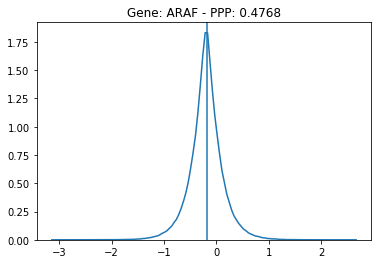

In [173]:
z = zs['PARP1'].ravel()

z_true = sample['PARP1']
ppp = round(sum(z_true < z) / len(z), 4)

plt.title(f'Gene: {gene} - PPP: {ppp}')
plt.axvline(sample['PARP1'])
sns.kdeplot(z)

## Ensure you get same results when PARP1 and ARAF are not included

In [4]:
training_genes = r.outlier.select_k_best_genes(normal, genes, 'tissue', n=50)

In [5]:
m0, t0 = r.outlier.run_model(sample, normal, 'tissue', 
                             training_genes=training_genes,
                             beta_func=pm.LogitNormal)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [10:22<00:00,  9.04draws/s] 
The acceptance probability does not match the target. It is 0.6975458707552663, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


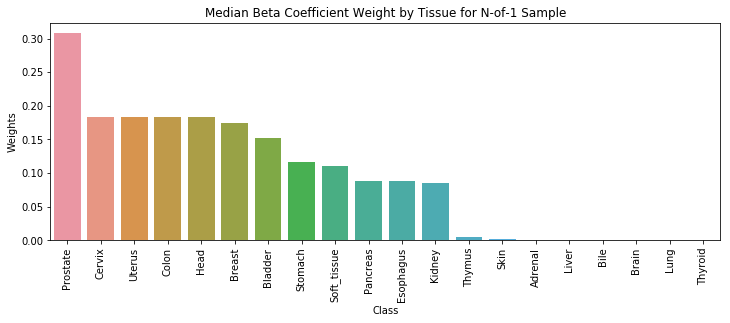

In [8]:
r.outlier.plot_weights(classes, t0);

In [10]:
ppc = r.outlier.ppc_from_coefs(t0, ['ARAF', 'PARP1'], normal, 'tissue')

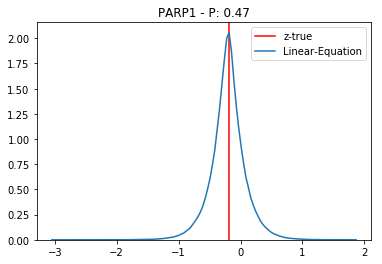

In [19]:
gene = 'PARP1'
pvals = r.outlier.posterior_predictive_pvals(sample, ppc)
z = ppc[gene].ravel()

plt.axvline(sample[gene], color='red', label='z-true')
plt.title(f'{gene} - P: {pvals[gene]}')
sns.kdeplot(z, label='Linear-Equation')

# Try PPC for PCA by Proxying Epsilon

In [197]:
genes = ['ARAF', 'PARP1']

In [204]:
codes = {cat: i for i, cat in enumerate(normal['tissue'].unique())}

In [210]:
t_pca['b'][i, codes['Adrenal']]

0.0003533197334813663

In [213]:
[t_pca['b'][i, codes[x]] for x in codes]

[0.0003533197334813663,
 0.059415241874622764,
 0.0821961584786163,
 1.9573406128975553e-06,
 1.743502910524485e-05,
 0.35888762445828803,
 5.9728552999786404e-06,
 0.0011393254491032546,
 0.20538926827351425,
 0.00023429198712251223,
 0.06449450825061673,
 0.000849741311665932,
 0.19608542939906443,
 0.5831032070893788,
 0.3034778368639362,
 0.00023601509112820598,
 0.12044496495758795,
 0.0008093694007896496,
 0.005024453394622621,
 0.048351661532065174]

In [214]:
# Calculate posterior from linear model
zs = {gene: np.zeros((500, len(normal))) for gene in genes}
for i in tqdm(range(500), total=500):
    z = t_pca['a'][i] + normal[genes].mul([t_pca['b'][i, codes[x]] for x in normal.tissue], axis=0)
    for gene in z.columns:
        zs[gene][i, :] = np.random.laplace(loc=z[gene], scale=trace['eps'].mean())

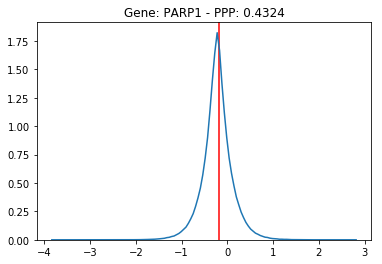

In [218]:
gene = 'PARP1'
z = zs[gene].ravel()

z_true = sample[gene]
ppp = round(sum(z_true < z) / len(z), 4)

plt.title(f'Gene: {gene} - PPP: {ppp}')
plt.axvline(z_true, c='r')
sns.kdeplot(z)

# Normalization Scheme
1. Normalize all data between -1 and 1 (or 0,1)
2. Run PCA
3. Renormalize values
4. Train Model
5. PPC / PVAL

## Normalize data

In [77]:
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt.hd5')

In [78]:
sub = df[genes]
sub_min = sub.min()
df[genes] = (sub - sub_min) / (sub.max() - sub_min)

In [79]:
normal = df[df.label == 'tcga-normal']

## Run PCA

In [80]:
n = 50
X_genes = [f'Gene{x}' for x in range(n)]
pca = PCA(n_components=n)

In [81]:
sample = df.loc['TCGA-KK-A7B2-01']

In [82]:
combined_df = normal.append(sample)

In [109]:
genes = df.columns[5:]
#pca_genes = r.outlier.select_k_best_genes(normal, genes, 'tissue', 100)
X = pd.DataFrame(pca.fit_transform(combined_df[genes]))

Renormalize values

In [110]:
X = (X - X.min()) / (X.max() - X.min())

In [111]:
y = pd.Series(X.iloc[-1])
y.index = X_genes

In [112]:
X = X.iloc[:-1]
X.index = normal.index
X.columns = X_genes

In [113]:
for col in df.columns[:5]:
    X[col] = df[col]
    y[col] = sample[col]

## Train Model

In [114]:
_, t_pca = r.outlier.run_model(y, X, 'tissue', 
                               training_genes=X_genes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [06:23<00:00, 15.66draws/s]
The number of effective samples is smaller than 25% for some parameters.


Weight Plot

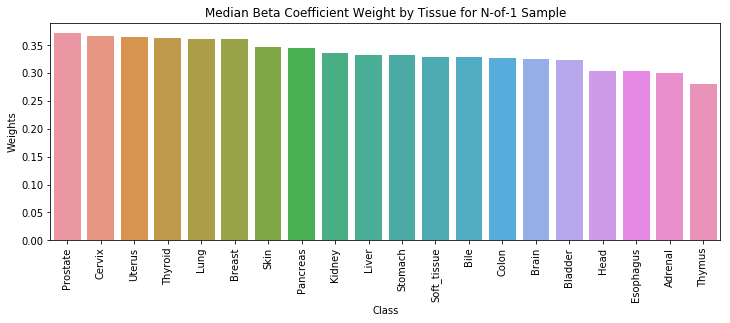

In [115]:
r.outlier.plot_weights(classes, t_pca)

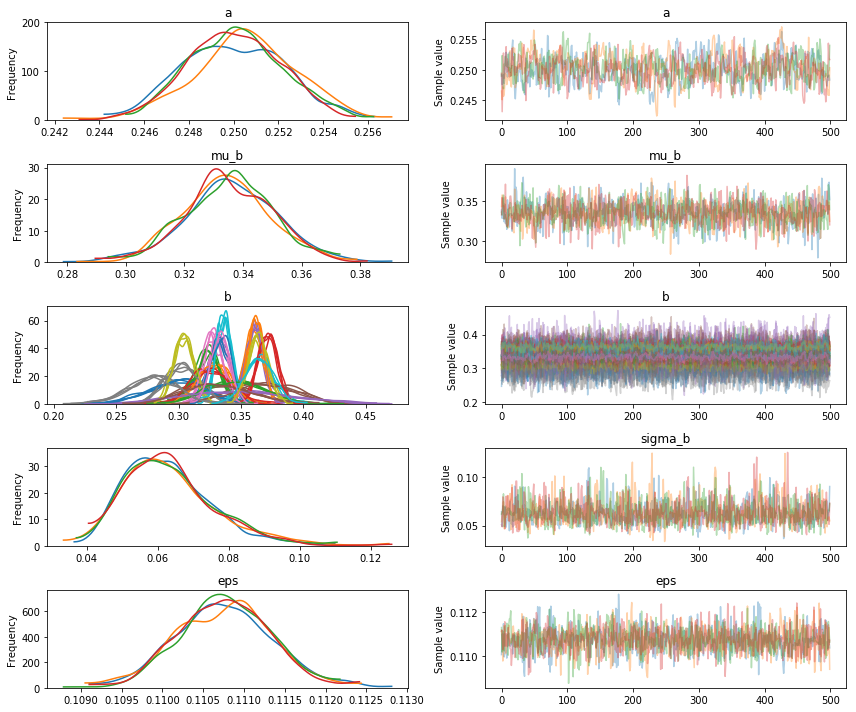

In [116]:
pm.traceplot(t_pca);

## PPC / PVAL

In [117]:
ppc = r.outlier.ppc_from_coefs(t_pca, drug_genes, normal, 'tissue', 500)
ppps = r.outlier.posterior_predictive_pvals(sample, ppc)

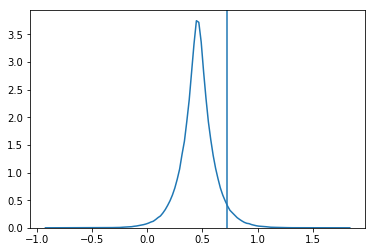

In [120]:
plt.axvline(sample['ARAF'])
sns.kdeplot(ppc['ARAF'])

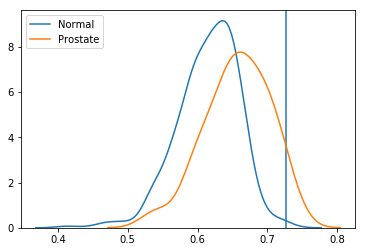

In [119]:
plt.axvline(sample['ARAF'])
sns.kdeplot(normal['ARAF'], label='Normal')
sns.kdeplot(normal[normal.tissue == 'Prostate']['ARAF'], label='Prostate')